# Zadanie rekrutacyjne

Notatnik zawiera implementacje porównywania dwóch obrazów formatu DICOM.

**Wykonał: Michał Kokoszkiewicz**

## Biblioteki

Notatnik był wykonywany w środowisku Colab, ale bez problemu można odpalić go na dowolnym innym środowisku z odpowiednio zainstalowanymi potrzebnymi bibliotekami oraz kompatyblinej wersji Python 3.x

W środowisku Colab musimy zainstalować tylko bibliotekę pydicom. W przypadku uruchomienia notatnika na innym środowisku należy odkomnetować komórki z instalacją potrzebnych bibliotek oraz je zaimportować.

In [1]:
# !pip install matplotlib
# !pip install opencv-python
# !pip install numpy
# !pip install scikit-image
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00


In [2]:
import pydicom
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from skimage.metrics import structural_similarity as ssim

## Wczytywanie

Z Internetu pobrałem plik DICOM, który zawierał serię 96 zdjęć.

W takim przypadku, seria jest wczytywana do zmiennej 'series' jako tablica pikseli (pixel_array) obiektu DICOM.

Źródło pliku DICOM: https://www.rubomedical.com/dicom_files/

In [3]:
# Tutaj wczytujemy plik z odpowiedniej ścieżki
ds = pydicom.dcmread('/content/0002.DCM')

# Sprawdź, czy plik DICOM zawiera więcej niż jedno zdjęcie
if 'NumberOfFrames' in ds:
    # Wczytaj serię zdjęć
    series = ds.pixel_array
    print("Wczytano serię {} zdjęć.".format(series.shape[0]))
else:
    print("Ten plik DICOM zawiera tylko jedno zdjęcie.")

Wczytano serię 96 zdjęć.


Wypisanie podstawowych właściwości obrazów z pliku DICOM.

In [4]:
print(f"Podstawowe właściwości obrazów:")
print("1. Rozmiar obrazu:", ds.Rows, "x", ds.Columns)
print("2. Głębia bitowa:", ds.BitsStored, "bit")
print("3. Modality:", ds.Modality)
print("4. Przestrzeń kolorów:", ds.PhotometricInterpretation)

Podstawowe właściwości obrazów:
1. Rozmiar obrazu: 512 x 512
2. Głębia bitowa: 8 bit
3. Modality: XA
4. Przestrzeń kolorów: MONOCHROME2


Wyświetlamy kilka przykładowych zdjęć z serii obrazów.

Jak widzimy zdjęcia różnią się od siebie w różnym stopniu, więc jest to idealny zbiór do przetestowania metryk podobieństwa.

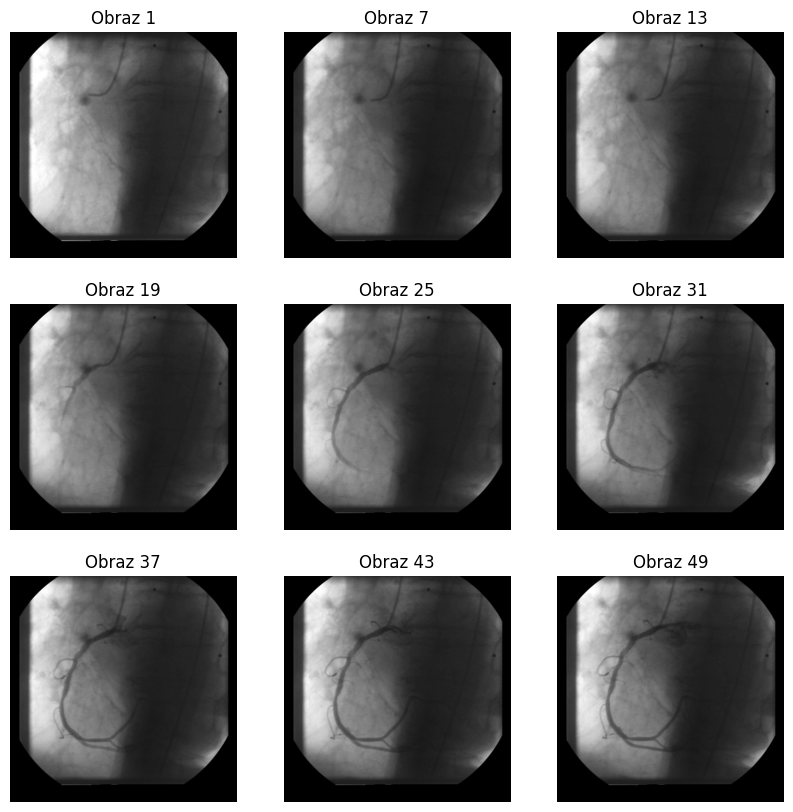

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    index = i * 6
    ax.imshow(series[index], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Obraz {index+1}')

plt.show()

To są obrazy na których będziemy sprawdzać miary podobieństwa:

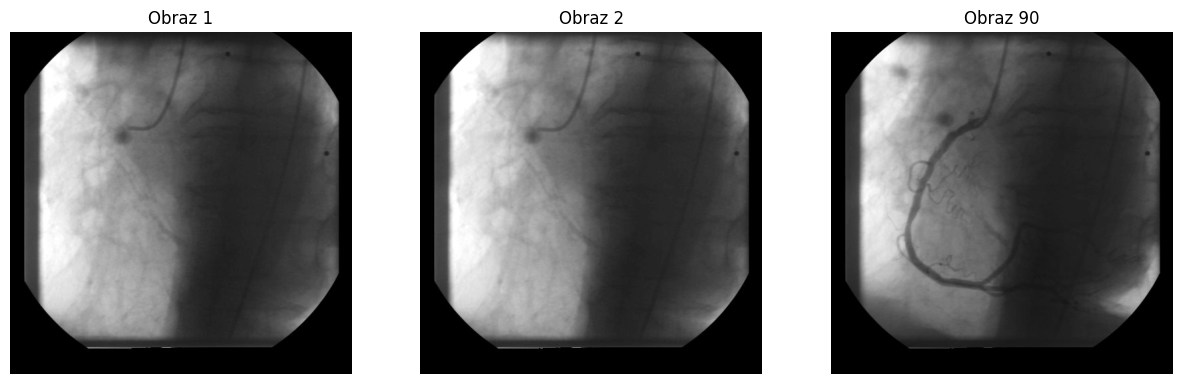

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(series[0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('Obraz 1')

axes[1].imshow(series[1], cmap='gray')
axes[1].axis('off')
axes[1].set_title('Obraz 2')

axes[2].imshow(series[89], cmap='gray')
axes[2].axis('off')
axes[2].set_title('Obraz 90')

plt.show()

## Porównania

W tej komórce wybieramy indeksy obrazów w serii, które chcemy ze sobą porównać.

In [6]:
index_image1 = 0
index_image2 = 1

image1 = series[index_image1]
image2 = series[index_image2]

### Miara podobieństwa histogramów

Miara podobieństwa oparta na porównaniu histogramów jest metodą oceny podobieństwa między dwoma obrazami poprzez porównanie ich histogramów pikseli. Histogram obrazu to graficzne przedstawienie rozkładu intensywności pikseli w obrazie.

In [7]:
image1 = series[0]
image2 = series[1]

histogram1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
histogram2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

# Normalizacja histogramów
histogram1 /= histogram1.sum()
histogram2 /= histogram2.sum()

# Porównanie histogramów za pomocą miary podobieństwa
histogram_similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

print("Miara podobieństwa histogramów pomiędzy 1 a 2 obrazem w serii:", histogram_similarity)

Miara podobieństwa histogramów pomiędzy 1 a 2 obrazem w serii: 0.9522018432617188


Miara podobieństwa histogramów między obrazem 1 a 2 w serii wynosi 0.95. Oznacza to, że istnieje pomiędzy nimi wysokie podobieństwo.

Im bliżej wartość miary podobieństwa jest do 1, tym większe jest podobieństwo między histogramami, a wartość 1 oznacza, że histogramy są identyczne. Wartość 0 oznacza brak podobieństwa.

In [8]:
image1 = series[0]
image2 = series[89]

histogram1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
histogram2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

histogram1 /= histogram1.sum()
histogram2 /= histogram2.sum()

histogram_similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

print("Miara podobieństwa histogramów pomiędzy 1 a 90 obrazem w serii:", histogram_similarity)

Miara podobieństwa histogramów pomiędzy 1 a 90 obrazem w serii: 0.8267860412597656


Miara podobieństwa histogramów między obrazem 1 a 90 w serii wynosi 0.826. Oznacza to, że istnieje pomiędzy nimi o wiele większa różnica niż między 1 a 2 obrazem.

In [9]:
image1 = series[0]
image2 = series[0]

histogram1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
histogram2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

histogram1 /= histogram1.sum()
histogram2 /= histogram2.sum()

histogram_similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

print("Miara podobieństwa histogramów pomiędzy 1 a 1 obrazem w serii:", histogram_similarity)

Miara podobieństwa histogramów pomiędzy 1 a 1 obrazem w serii: 1.0


Przetestowanie miary porównaniem dwóch takich samych obrazów. Wynik to 1, więc miara działa prawidłowo, wskazuje że obrazy są identyczne.

### Miara SSIM

Indeks podobieństwa strukturalnego (SSIM - Structural Similarity Index) to miara oceny podobieństwa między dwoma obrazami, która bierze pod uwagę trzy aspekty: podobieństwo strukturalne, podobieństwo jasności i podobieństwo kontrastu. SSIM mierzy lokalne podobieństwo między pikselami dwóch obrazów i generuje pojedynczą wartość SSIM dla całego obrazu. Indeks SSIM jest wyrażany w zakresie od -1 do 1, gdzie wartość 1 oznacza doskonałe podobieństwo między obrazami, 0 oznacza brak podobieństwa, a wartość -1 oznacza doskonałe przeciwieństwo.


In [10]:
image1 = series[0]
image2 = series[1]

ssim_index = ssim(image1, image2)

print("Miara podobieństwa SSIM pomiędzy 1 a 2 obrazem w serii:", ssim_index)

Miara podobieństwa SSIM pomiędzy 1 a 2 obrazem w serii: 0.9585013342007128


Wartość SSIM pomiędzy 1 a 2 obrazem w serii wynosi około 0.958, co wskazuje na wysoki poziom podobieństwa między obrazami.

In [11]:
image1 = series[0]
image2 = series[89]

ssim_index = ssim(image1, image2)

print("Miara podobieństwa SSIM pomiędzy 1 a 90 obrazem w serii:", ssim_index)

Miara podobieństwa SSIM pomiędzy 1 a 90 obrazem w serii: 0.8349206005190453


Miara podobieństwa histogramów między obrazem 1 a 90 w serii wynosi 0.834. Oznacza to, że istnieje pomiędzy nimi o wiele większa różnica niż między 1 a 2 obrazem.

In [12]:
image1 = series[0]
image2 = series[0]

ssim_index = ssim(image1, image2)

print("Miara podobieństwa SSIM pomiędzy 1 a 1 obrazem w serii:", ssim_index)

Miara podobieństwa SSIM pomiędzy 1 a 1 obrazem w serii: 1.0


Przetestowanie miary porównaniem dwóch takich samych obrazów. Wynik to 1, więc miara działa prawidłowo, wskazuje że obrazy są identyczne.

### Miara podobieństwa gradientów

Gradient obrazu to wektor, który określa kierunek i szybkość zmiany intensywności pikseli w obrazie. Miara ta bada podobieństwo między gradientami obrazów, aby stwierdzić, czy obrazy mają podobne struktury i tekstury.

Im większa wartość, tym większa jest różnica między gradientami obrazów. Może to wskazywać na różnice w strukturach lub cechach obrazów. Im niższa wartość, tym większe podobieństwo między gradientami obrazów, a więc większe podobieństwo między samymi obrazami.

In [13]:
image1 = series[0]
image2 = series[1]

# Oblicz gradienty obrazów za pomocą operatora Sobela
gradient_x1 = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)
gradient_y1 = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)
gradient1 = cv2.magnitude(gradient_x1, gradient_y1)

gradient_x2 = cv2.Sobel(image2, cv2.CV_64F, 1, 0, ksize=3)
gradient_y2 = cv2.Sobel(image2, cv2.CV_64F, 0, 1, ksize=3)
gradient2 = cv2.magnitude(gradient_x2, gradient_y2)

# Oblicz różnicę między gradientami obrazów
gradient_diff = cv2.absdiff(gradient1, gradient2)

# Oblicz średnią wartość różnicy gradientów
mean_gradient_diff = cv2.mean(gradient_diff)[0]

print("Średnia wartość różnicy gradientów pomiędzy 1 a 2 obrazem w serii:", mean_gradient_diff)

Średnia wartość różnicy gradientów pomiędzy 1 a 2 obrazem w serii: 5.038058679059018


Średnia wartość różnicy gradientów pomiędzy 1 a 2 obrazem w serii wynosi 5.03. Wskazuje to na to, że występują pomiędzy tymi obrazami niewielkie różnice w krawędziach, liniach lub teksturach.

In [14]:
image1 = series[0]
image2 = series[89]

gradient_x1 = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)
gradient_y1 = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)
gradient1 = cv2.magnitude(gradient_x1, gradient_y1)

gradient_x2 = cv2.Sobel(image2, cv2.CV_64F, 1, 0, ksize=3)
gradient_y2 = cv2.Sobel(image2, cv2.CV_64F, 0, 1, ksize=3)
gradient2 = cv2.magnitude(gradient_x2, gradient_y2)

gradient_diff = cv2.absdiff(gradient1, gradient2)

mean_gradient_diff = cv2.mean(gradient_diff)[0]

print("Średnia wartość różnicy gradientów pomiędzy 1 a 90 obrazem w serii:", mean_gradient_diff)

Średnia wartość różnicy gradientów pomiędzy 1 a 90 obrazem w serii: 9.216809945672543


Średnia wartość różnicy gradientów pomiędzy 1 a 90 obrazem w serii wynosi 9.21. Wskazuje to na to, że występują pomiędzy tymi obrazami większe różnice w krawędziach, liniach lub teksturach. Jest to prawie podwójna wartość w porównaniu do podobieństwa gradientów 1 i 2 obrazu.

In [15]:
image1 = series[0]
image2 = series[0]

gradient_x1 = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)
gradient_y1 = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)
gradient1 = cv2.magnitude(gradient_x1, gradient_y1)

gradient_x2 = cv2.Sobel(image2, cv2.CV_64F, 1, 0, ksize=3)
gradient_y2 = cv2.Sobel(image2, cv2.CV_64F, 0, 1, ksize=3)
gradient2 = cv2.magnitude(gradient_x2, gradient_y2)

gradient_diff = cv2.absdiff(gradient1, gradient2)

mean_gradient_diff = cv2.mean(gradient_diff)[0]

print("Średnia wartość różnicy gradientów pomiędzy 1 a 1 obrazem w serii:", mean_gradient_diff)

Średnia wartość różnicy gradientów pomiędzy 1 a 1 obrazem w serii: 0.0


Przetestowanie miary porównaniem dwóch takich samych obrazów. Wynik to 0, więc miara działa prawidłowo, wskazuje że obrazy są identyczne.

### Miara korelacji Pearsona

Korelacja Pearsona to miara statystyczna, która mierzy stopień liniowej zależności między dwiema zmiennymi. W kontekście analizy obrazów, korelacja Pearsona może być używana do oceny podobieństwa między dwoma obrazami poprzez porównanie wartości pikseli w tych obrazach.

Aby obliczyć korelację Pearsona między dwoma obrazami, najpierw obliczamy wartości pikseli dla każdego obrazu. Następnie obliczamy średnią wartość pikseli dla obu obrazów oraz odchylenie standardowe wartości pikseli dla każdego z nich. Na podstawie tych wartości możemy obliczyć współczynnik korelacji Pearsona, który określa, jak bardzo zmiany w jednym obrazie są skorelowane ze zmianami w drugim obrazie.

Wartości miary są wyrażanone w zakresie od -1 do 1, gdzie wartość 1 oznacza doskonałe podobieństwo między obrazami, 0 oznacza brak podobieństwa, a wartość -1 oznacza doskonałe przeciwieństwo.

In [16]:
image1 = series[0]
image2 = series[1]

correlation = np.corrcoef(image1.flatten(), image2.flatten())[0, 1]

print("Miara korelacji Pearsona pomiędzy 1 a 2 obrazem w serii:", "{:.3f}".format(correlation))

Miara korelacji Pearsona pomiędzy 1 a 2 obrazem w serii: 0.991


Wartość korelacji Pearsona pomiędzy 1 a 2 obrazem w serii wynosi 0.99, co wskazuje na bardzo silną dodatnią korelację między dwoma obrazami. Im bliżej wartości 1, tym silniejsza jest liniowa zależność między pikselami obrazów.

In [17]:
image1 = series[0]
image2 = series[89]

correlation = np.corrcoef(image1.flatten(), image2.flatten())[0, 1]

print("Miara korelacji Pearsona pomiędzy 1 a 90 obrazem w serii:", "{:.3f}".format(correlation))

Miara korelacji Pearsona pomiędzy 1 a 90 obrazem w serii: 0.947


Wartość korelacji Pearsona pomiędzy 1 a 90 obrazem w serii wynosi 0.947, co wskazuje, że obrazy różnią się bardziej.

In [18]:
image1 = series[0]
image2 = series[0]

correlation = np.corrcoef(image1.flatten(), image2.flatten())[0, 1]

print("Miara korelacji Pearsona pomiędzy 1 a 1 obrazem w serii:", "{:.3f}".format(correlation))

Miara korelacji Pearsona pomiędzy 1 a 1 obrazem w serii: 1.000


Przetestowanie miary porównaniem dwóch takich samych obrazów. Wynik to 1, więc miara działa prawidłowo, wskazuje że obrazy są identyczne.

### Miara podobieństwa oparta na GLCM

Zaimplementowana poniżej miara podobieństwa opiera się na analizie tekstury obrazów za pomocą macierzy kowariancji szarości (GLCM - Gray-Level Co-occurrence Matrix). GLCM to macierz, która reprezentuje występowanie wzorców pikseli w obrazie poprzez śledzenie ich współwystępowania z określonymi odległościami i kątami.

Im mniejsza jest odległość między parametrami tekstury obrazów, tym większa jest ich podobieństwo teksturalne. Natomiast większa odległość wskazuje na większą różnorodność między obrazami pod względem cech tekstury.

In [19]:
# Funkcja obliczająca entropię
def entropy(p):
    p = p.ravel()
    return -np.dot(p, np.log2(p + (p == 0)))

In [20]:
image1 = series[0]
image2 = series[1]

# Macierz kowariancji tekstury dla pierwszego obrazu
glcm1 = graycomatrix(image1, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

# Parametry tekstury z macierzy kowariancji (energia, entropia, kontrast)
contrast1 = graycoprops(glcm1, prop='contrast')
energy1 = graycoprops(glcm1, prop='energy')
entropy1 = entropy(glcm1[:, :, 0, 0])

# Analogicznie dla drugiego obrazu
glcm2 = graycomatrix(image2, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast2 = graycoprops(glcm2, prop='contrast')
energy2 = graycoprops(glcm2, prop='energy')
entropy2 = entropy(glcm2[:, :, 0, 0])

print("Parametry tekstury dla obrazu 1:")
print("Kontrast:", contrast1)
print("Energia:", energy1)
print("Entropia dla obrazu 1:", entropy1)

print("Parametry tekstury dla obrazu 2:")
print("Kontrast:", contrast2)
print("Energia:", energy2)
print("Entropia dla obrazu 2:", entropy2)

# Różnica między parametrami tekstury obrazów
contrast_diff = np.abs(contrast1 - contrast2)
energy_diff = np.abs(energy1 - energy2)
entropy_diff = np.abs(entropy1 - entropy2)

# Odległość między parametrami tekstury (odległość euklidesowa)
texture_distance = np.sqrt(contrast_diff**2 + energy_diff**2 + entropy_diff**2)
print("---------------------------------------------------")
print("Odległość między parametrami tekstury pomiędzy 1 a 2 obrazem w serii:", texture_distance)

Parametry tekstury dla obrazu 1:
Kontrast: [[23.11445083]]
Energia: [[0.19742621]]
Entropia dla obrazu 1: 9.051355237116745
Parametry tekstury dla obrazu 2:
Kontrast: [[24.95021251]]
Energia: [[0.19808145]]
Entropia dla obrazu 2: 9.068467638573914
---------------------------------------------------
Odległość między parametrami tekstury pomiędzy 1 a 2 obrazem w serii: [[1.83584155]]


Wartość odległości między parametrami tekstury pomiędzy 1 a 2 obrazem w serii wynosi 1.835. Taka odległość ta sugeruje, że obrazy mają podobne cechy teksturalne.

In [21]:
image1 = series[0]
image2 = series[89]

glcm1 = graycomatrix(image1, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

contrast1 = graycoprops(glcm1, prop='contrast')
energy1 = graycoprops(glcm1, prop='energy')
entropy1 = entropy(glcm1[:, :, 0, 0])

glcm2 = graycomatrix(image2, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast2 = graycoprops(glcm2, prop='contrast')
energy2 = graycoprops(glcm2, prop='energy')
entropy2 = entropy(glcm2[:, :, 0, 0])

print("Parametry tekstury dla obrazu 1:")
print("Kontrast:", contrast1)
print("Energia:", energy1)
print("Entropia dla obrazu 1:", entropy1)

print("Parametry tekstury dla obrazu 2:")
print("Kontrast:", contrast2)
print("Energia:", energy2)
print("Entropia dla obrazu 2:", entropy2)

contrast_diff = np.abs(contrast1 - contrast2)
energy_diff = np.abs(energy1 - energy2)
entropy_diff = np.abs(entropy1 - entropy2)

texture_distance = np.sqrt(contrast_diff**2 + energy_diff**2 + entropy_diff**2)
print("---------------------------------------------------")
print("Odległość między parametrami tekstury pomiędzy 1 a 90 obrazem w serii:", texture_distance)

Parametry tekstury dla obrazu 1:
Kontrast: [[23.11445083]]
Energia: [[0.19742621]]
Entropia dla obrazu 1: 9.051355237116745
Parametry tekstury dla obrazu 2:
Kontrast: [[20.05190497]]
Energia: [[0.19984996]]
Entropia dla obrazu 2: 8.821556181716193
---------------------------------------------------
Odległość między parametrami tekstury pomiędzy 1 a 90 obrazem w serii: [[3.07115624]]


Wartość odległości między parametrami tekstury pomiędzy 1 a 90 obrazem w serii wynosi 3.071. Taka odległość ta sugeruje, że obrazy mają bardziej zróżnicowane cechy teksturalne.

In [22]:
image1 = series[0]
image2 = series[0]

glcm1 = graycomatrix(image1, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

contrast1 = graycoprops(glcm1, prop='contrast')
energy1 = graycoprops(glcm1, prop='energy')
entropy1 = entropy(glcm1[:, :, 0, 0])

glcm2 = graycomatrix(image2, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast2 = graycoprops(glcm2, prop='contrast')
energy2 = graycoprops(glcm2, prop='energy')
entropy2 = entropy(glcm2[:, :, 0, 0])

print("Parametry tekstury dla obrazu 1:")
print("Kontrast:", contrast1)
print("Energia:", energy1)
print("Entropia dla obrazu 1:", entropy1)

print("Parametry tekstury dla obrazu 2:")
print("Kontrast:", contrast2)
print("Energia:", energy2)
print("Entropia dla obrazu 2:", entropy2)

contrast_diff = np.abs(contrast1 - contrast2)
energy_diff = np.abs(energy1 - energy2)
entropy_diff = np.abs(entropy1 - entropy2)

texture_distance = np.sqrt(contrast_diff**2 + energy_diff**2 + entropy_diff**2)
print("---------------------------------------------------")
print("Odległość między parametrami tekstury pomiędzy 1 a 1 obrazem w serii:", texture_distance)

Parametry tekstury dla obrazu 1:
Kontrast: [[23.11445083]]
Energia: [[0.19742621]]
Entropia dla obrazu 1: 9.051355237116745
Parametry tekstury dla obrazu 2:
Kontrast: [[23.11445083]]
Energia: [[0.19742621]]
Entropia dla obrazu 2: 9.051355237116745
---------------------------------------------------
Odległość między parametrami tekstury pomiędzy 1 a 1 obrazem w serii: [[0.]]


Przetestowanie miary porównaniem dwóch takich samych obrazów. Wynik to 0, więc miara działa prawidłowo, wskazuje że obrazy są identyczne.